In [86]:
import csv
import os
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS

import astropy.units as u
import astropy.io.fits as fits
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const

import torch
print(torch.cuda.is_available())
from transformers import pipeline
from PIL import Image
import open3d as o3d

from skimage.measure import shannon_entropy
from sklearn.ensemble import IsolationForest
from scipy.ndimage import zoom
from skimage.exposure import equalize_adapthist

True


manga_products = Observations.get_product_list(manga_obs_list)

manga_maps = Observations.filter_products(manga_products,
                                          mrp_only=True,
                                          productSubGroupDescription="MAPS")

len(manga_maps)
Observations.download_products(manga_maps, download_dir='../../universe', flat=True)

In [210]:
data_folder = '../../universe'

maps_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]
len(maps_files)

10116

In [211]:
lookback_times = []
n=1
for file in maps_files:
    with fits.open(file) as manga_map:
            
        primary_header = manga_map['PRIMARY'].header
        plateifu = primary_header.get("PLATEIFU", None)
        scinpvel = primary_header.get("SCINPVEL", None)

        if scinpvel is not None:
            # redshift z = v / c
            z = scinpvel / const.c.to('km/s').value
            lookback_time = cosmo.lookback_time(z).to('Gyr').value
            lookback_times.append(lookback_time)
        
        print(f'{n}/{len(maps_files)}', end='\r')
        n+=1

In [212]:
fps = 60
lookbacktimes = np.unique(lookback_times)
n_lookbacktimes = len(lookbacktimes)
print(f'[Unique Years]: {n_lookbacktimes}')

# diffs = [b - a for a, b in zip(lookbacktimes, lookbacktimes[1:])]
diffs = np.diff(lookbacktimes) # same as above, but more efficient
print(f'[Diffs] | Mean: {np.mean(diffs):.6f} Gyr | Q1: {np.percentile(diffs, 25):.6f} Gyr | Median: {np.median(diffs):.6f} Gyr | Q3: {np.percentile(diffs, 75):.6f} Gyr')

percentile = 90
step_size = np.percentile(diffs, percentile)
steps = np.arange(min(lookbacktimes), max(lookbacktimes), step_size)
frames = len(steps)

vid_length = frames / fps
m, s = divmod(vid_length, 60)
h, m = divmod(m, 60)

print(f'[Range]: {range:.3f} Gyr')
print(f'[Step size ({percentile}th percentile)]: {step_size} Gyr ({step_size * 1e9:.2f} years)')
print(f'[Video length]: {h:.0f}h {m:.0f}m {s:.2f}s ({int(frames)} frames)')


[Unique Years]: 9550
[Diffs] | Mean: 0.000348 Gyr | Q1: 0.000027 Gyr | Median: 0.000071 Gyr | Q3: 0.000177 Gyr
[Range]: 3.326 Gyr
[Step size (90th percentile)]: 0.00044971156828395103 Gyr (449711.57 years)
[Video length]: 0h 2m 3.27s (7396 frames)


[Zero steps]: 4629


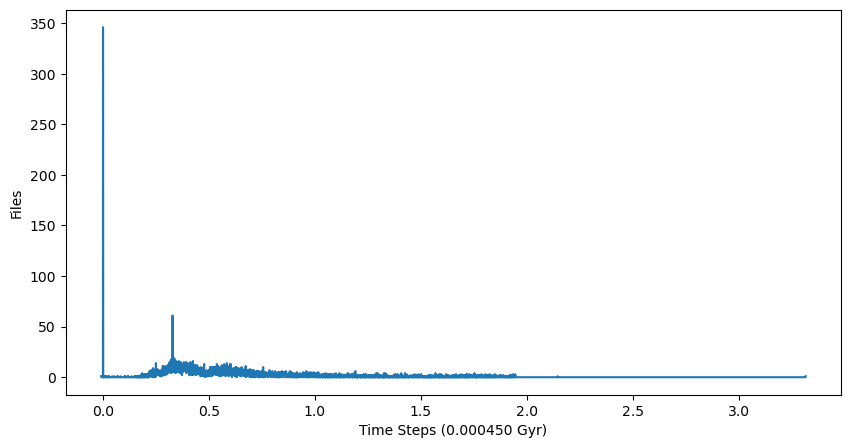

In [213]:
# check how many lookback_times are in each step
step_counts = np.zeros(len(steps))
for i, step in enumerate(steps):
    step_counts[i] = len([1 for t in lookback_times if t >= step and t < step + step_size])

# find where step_counts is 0
zero_steps = np.where(step_counts == 0)[0] # [0] for True
print(f'[Zero steps]: {len(zero_steps)}')

plt.figure(figsize=(10, 5));
plt.plot(steps, step_counts);
plt.xlabel(f'Time Steps ({step_size:.6f} Gyr)');
plt.ylabel('Files');

In [215]:
files = maps_files

points = []
i=1
for file in files:
    with fits.open(file) as manga_map:
                
        primary_header = manga_map['PRIMARY'].header
        plateifu = primary_header.get("PLATEIFU", None)
        scinpvel = primary_header.get("SCINPVEL", None)

        if scinpvel is not None:
            # redshift z = v / c
            z = scinpvel / const.c.to('km/s').value
            lookback_time = cosmo.lookback_time(z).to('Gyr').value
            d_L = cosmo.luminosity_distance(z).to(u.Mpc).value
        else:
            z = None
            lookback_time = None
            d_L = None
        
        print(f"({i}/{len(files)}) Plate-IFU: {plateifu} | z: {z} | Lookback time: {lookback_time:.4f} Gyr | Luminosity distance: {d_L:.4f} Mpc              ", end='\r')
        
        wcs = WCS(manga_map['EMLINE_GFLUX'].header)
        h_alpha_flux = manga_map['EMLINE_GFLUX'].data[23] # 24th channel
        
        nx, ny = h_alpha_flux.shape
        x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny), indexing="ij")

        # Convert spaxels to RA/Dec using WCS
        ra, dec, _ = wcs.all_pix2world(x_grid, y_grid, np.zeros_like(x_grid), 0)

        # Convert RA/Dec to Cartesian coordinates
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)

        X = d_L * np.cos(dec_rad) * np.cos(ra_rad)  # Mpc
        Y = d_L * np.cos(dec_rad) * np.sin(ra_rad)  # Mpc
        Z = d_L * np.sin(dec_rad)  # Mpc
        
        h_alpha_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), h_alpha_flux.ravel()]).T
        h_alpha_points = h_alpha_points[~np.isnan(h_alpha_points).any(axis=1)] # remove rows with NaNs
        # h_alpha_points = h_alpha_points[h_alpha_points[:, 3] != 0] # remove rows with 0 flux
        points.append(h_alpha_points)
    
        i+=1
        
with open(f'test_points2.csv', 'w') as f:
    f.write('X,Y,Z,H-alpha\n')
    for point in points:
        f.write('\n'.join([', '.join(map(str, p)) for p in point]))
        f.write('\n')

KeyboardInterrupt: 

range of positions is wide, so may need to normalize to 0,1 once all dataset files are downloaded?

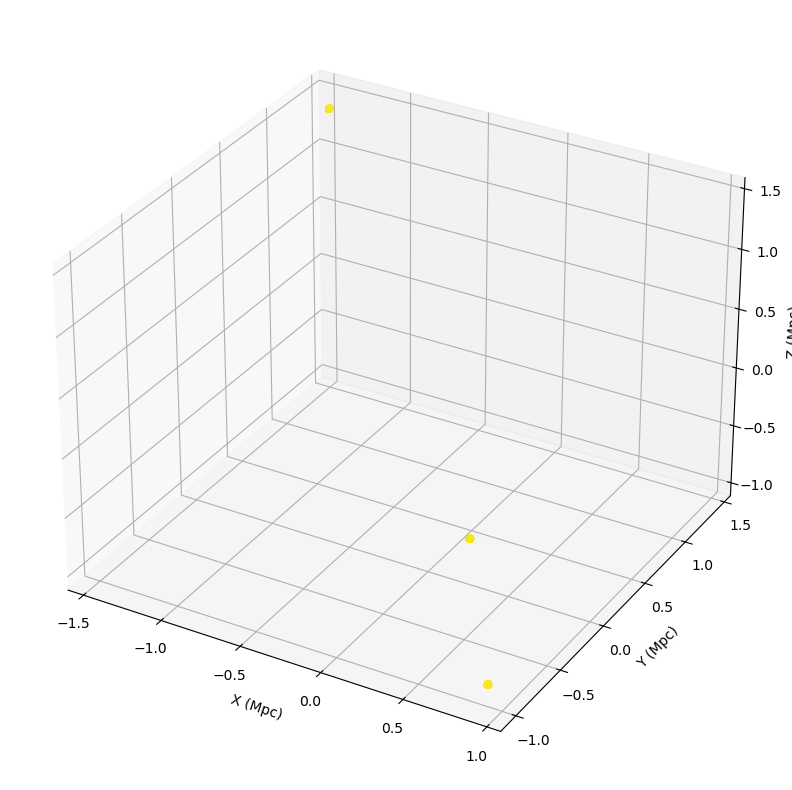

In [214]:
test_csv = pd.read_csv('test_points.csv', header=0)

# normalize data
test_csv['X'] = (test_csv['X'] - test_csv['X'].mean()) / test_csv['X'].std()
test_csv['Y'] = (test_csv['Y'] - test_csv['Y'].mean()) / test_csv['Y'].std()
test_csv['Z'] = (test_csv['Z'] - test_csv['Z'].mean()) / test_csv['Z'].std()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_csv['X'], test_csv['Y'], test_csv['Z'], c=test_csv['H-alpha'], cmap='viridis')
ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')
ax.set_zlabel('Z (Mpc)')
plt.show()

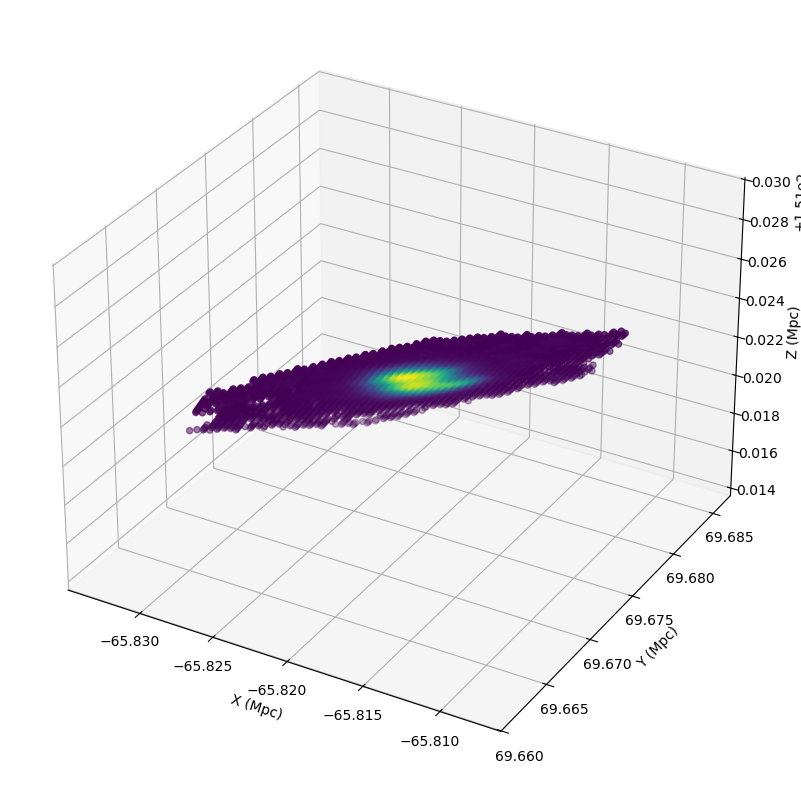

In [201]:
test_csv = pd.read_csv('test_points-10001-12701.csv', header=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_csv['X'], test_csv['Y'], test_csv['Z'], c=test_csv['H-Alpha Flux'], cmap='viridis')
ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')
ax.set_zlabel('Z (Mpc)')
plt.show()

[Channel 0] | Entropy: 4.3577166821969255 | Std: 81.85183715820312
[Channel 1] | Entropy: 4.386854141282167 | Std: 81.85743713378906
[Channel 2] | Entropy: 3.1792368642180637 | Std: 81.84077453613281
[Channel 3] | Entropy: 3.2702415598425976 | Std: 81.84100341796875
[Channel 4] | Entropy: 3.8595663096272705 | Std: 78.47500610351562
[Channel 5] | Entropy: 3.489862515726103 | Std: 76.14614868164062
[Channel 6] | Entropy: 3.559694014149674 | Std: 60.264930725097656
[Channel 7] | Entropy: 2.2539792726574825 | Std: 69.97604370117188
[Channel 8] | Entropy: 1.8982447965097273 | Std: 69.97569274902344
[Channel 9] | Entropy: 3.559694014149674 | Std: 60.26390838623047
[Channel 10] | Entropy: 3.284738628188795 | Std: 63.33791732788086
[Channel 11] | Entropy: 3.143163501103601 | Std: 50.44923782348633
[Channel 12] | Entropy: 3.967827922323398 | Std: 26.991971969604492
[Channel 13] | Entropy: 3.5653078769768887 | Std: 13.499019622802734
[Channel 14] | Entropy: 4.191103173133073 | Std: 13.5052042007

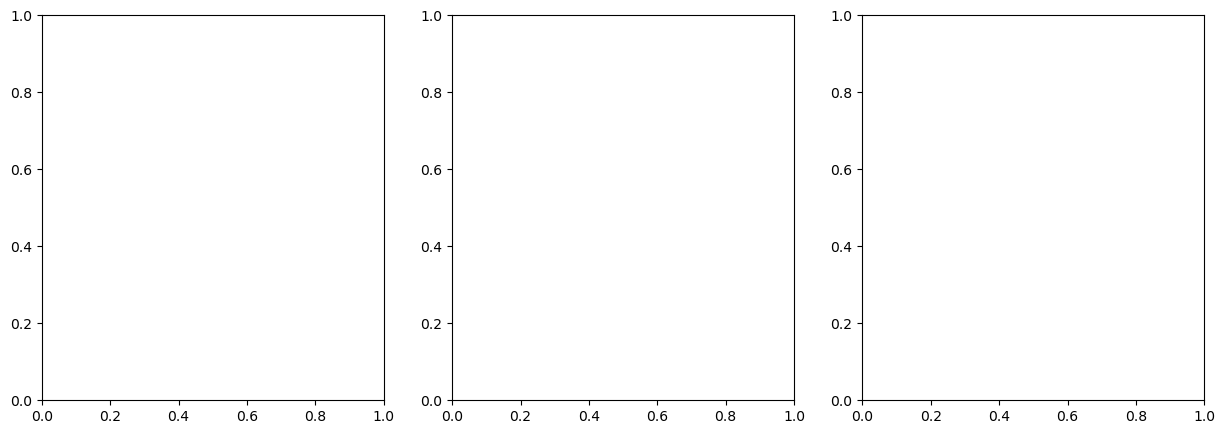

In [56]:
# make a grid plot of each emission line data hdul['EMLINE_GFLUX'].data[i]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
acceptable = [15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
with fits.open(file) as hdul: # 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29
    # ax[0].imshow(hdul['EMLINE_GFLUX'].data[23], origin='lower', cmap='viridis')
    # ax[1].imshow(hdul['EMLINE_GFLUX'].data[34], origin='lower', cmap='viridis')
    # ax[2].imshow(hdul['EMLINE_GFLUX'].data[33], origin='lower', cmap='viridis')
    for i in range(35):
        # calculate the entropy of the image
        img = hdul['EMLINE_GFLUX'].data[i]
        entropy = shannon_entropy(img)
        if i in acceptable:
            print(f'-->[Channel {i}] | Entropy: {entropy} | Std: {np.std(img)}')
        print(f'[Channel {i}] | Entropy: {entropy} | Std: {np.std(img)}')

C:\Users\ebaca\AppData\Local\Temp\ipykernel_13464\3624346458.py:20: RuntimeWarning: invalid value encountered in log1p
  image = np.log1p(image)
Device set to use cuda


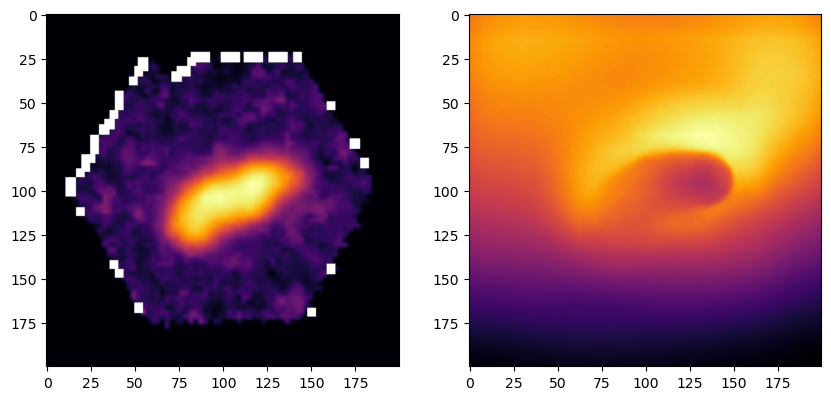

In [166]:
data_folder = '../../universe'
maps_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]

plateifu = '10001-12701'
file = next(f for f in maps_files if plateifu in f)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
with fits.open(file) as hdul:
    data = hdul['EMLINE_GFLUX'].data
    
    iso_forest = IsolationForest(contamination=0.5, random_state=42)  # 20% expected meaningful channels
    channels = [(shannon_entropy(data[i]), np.std(data[i])) for i in range(35)]
    labels = iso_forest.fit_predict(channels)
    selected_channels = np.where(labels == 1)[0]
    
    emission_flux = np.sum(hdul['EMLINE_GFLUX'].data[selected_channels], axis=0)
    g_band_flux = hdul['SPX_MFLUX'].data

image = emission_flux + g_band_flux
image = np.log1p(image)

x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
x_new = np.linspace(0, image.shape[1] - 1, 200)
y_new = np.linspace(0, image.shape[0] - 1, 200)
xv, yv = np.meshgrid(x_new, y_new)

interpolator = RegularGridInterpolator((y, x), image, method='linear') # "linear", "nearest", "slinear", "cubic", "quintic" and "pchip"
image = interpolator((yv, xv))

ax[0].imshow(image, cmap='inferno')

image_in = Image.fromarray(image).convert("RGB")

pipe = pipeline(task="depth-estimation", model="Intel/zoedepth-nyu-kitti", device='cuda');
# pipe = pipeline(task="depth-estimation", model="Intel/dpt-large", device='cuda');
result = pipe(image_in);
depth = result["depth"]
depth = np.array(depth) # * 1.99

depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))  # Normalize to [0,1]
depth = depth ** 1.5  # Apply non-linear scaling to exaggerate variations
depth = depth * 10

ax[1].imshow(depth, cmap='inferno')

In [ ]:
depth_o3d = o3d.geometry.Image((depth * 400).astype(np.uint8))
image_o3d = o3d.geometry.Image((image * 0.35))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

width, height = image.shape
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 1, 1, width / 2, height / 2)

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
# o3d.visualization.draw_geometries([pcd_raw])

cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=800, std_ratio=4)
pcd = pcd_raw.select_by_index(ind)
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
o3d.visualization.draw_geometries([pcd])

In [164]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=12, n_threads=6, scale=1)[0]
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))
# o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

mesh_uniform = mesh.filter_smooth_laplacian(5)
mesh_uniform.filter_sharpen()

mesh_uniform.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_uniform], mesh_show_back_face=True)

RuntimeError: [Open3D Error] (class std::tuple<class std::shared_ptr<class open3d::geometry::TriangleMesh>,class std::vector<double,class std::allocator<double> > > __cdecl open3d::geometry::TriangleMesh::CreateFromPointCloudPoisson(const class open3d::geometry::PointCloud &,unsigned __int64,float,float,bool,int)) D:\a\Open3D\Open3D\cpp\open3d\geometry\SurfaceReconstructionPoisson.cpp:731: Point cloud has no normals


In [ ]:
# o3d.io.write_triangle_mesh(f'{data_folder}/touchdesigner/{plateifu}.obj', mesh)

[Open3D WARNING] Write OBJ failed: unable to open file.


False